In [ ]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import pandas as pd
import pdb
import numpy as np
import cv2
import random
from crnn import CRNN as crnn

In [ ]:
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/vocabulary_semantic.txt

--2021-04-01 01:30:33--  https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/vocabulary_semantic.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33921 (33K) [text/plain]
Saving to: ‘vocabulary_semantic.txt’

vocabulary_semantic 100%[===================>]  33.13K  --.-KB/s    in 0.001s  

2021-04-01 01:30:34 (34.3 MB/s) - ‘vocabulary_semantic.txt’ saved [33921/33921]



In [ ]:
# You can get more datasets here https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/
!wget https://grfia.dlsi.ua.es/primus/packages/primusCalvoRizoAppliedSciences2018.tgz
!wget https://grfia.dlsi.ua.es/primus/packages/CameraPrIMuS.tgz

In [ ]:
!tar -xvf CameraPrIMuS.tgz 
!tar -xvf primusCalvoRizoAppliedSciences2018.tgz 

In [ ]:
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/ctc_utils.py
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/primus.py 

In [ ]:
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/train.txt
!wget https://raw.githubusercontent.com/OMR-Research/tf-end-to-end/master/Data/test.txt

In [ ]:
!wget https://raw.githubusercontent.com/meijieru/crnn.pytorch/master/models/crnn.py

--2021-04-01 05:29:03--  https://raw.githubusercontent.com/meijieru/crnn.pytorch/master/models/crnn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2554 (2.5K) [text/plain]
Saving to: ‘crnn.py’

crnn.py             100%[===================>]   2.49K  --.-KB/s    in 0s      

2021-04-01 05:29:04 (42.5 MB/s) - ‘crnn.py’ saved [2554/2554]



In [ ]:
class MusicClassificationObject:

  def __init__(self, dataset_dir, dataset_filenames, dictionary_path, transform=None, distortions=False):
        self.distortions = distortions
        self.dataset_dir = dataset_dir
        self.transform = transform 

        dataset_filenames = open(dataset_filenames,'r')
        dataset_list = dataset_filenames.read().splitlines()
        dataset_filenames.close()

        self.current_idx = 0

        # Dictionary
        self.symbol2index = {}
        self.index2symbol = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        word_idx = 0
        for word in dict_list:
          self.symbol2index[word] = word_idx
          self.index2symbol[word_idx] = word
          word_idx += 1 

        dict_file.close()

        self.dataset = self.createDataset(dataset_list)
        self.vocabulary_size = len(self.symbol2index)
  
  def createDataset(self, dataset_list):
    dataset = []
    i = 0
    for sample in dataset_list:
      sample_filepath = self.dataset_dir + '/' + sample + '/' + sample
      sample_semantic = sample_filepath + '.semantic'
      sample_gt_file = open(sample_semantic, 'r')
      sample_gt_plain = sample_gt_file.readline().split()
      sample_gt_file.close()
      # (img file name, all the notations sequentially related to the file)
      dataset.append((sample_filepath + '.png', [self.symbol2index[lab] for lab in sample_gt_plain]))
    return dataset

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, i):
    if torch.is_tensor(i):
        i = i.item()
    imgfn, label = self.dataset[i]
    img = PIL.Image.open(imgfn)
    if self.transform:
        img = self.transform(img)
    return (img, label)


In [ ]:
xform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
music_dataset = MusicClassificationObject('Corpus', 'train.txt', 'vocabulary_semantic.txt', xform)

In [ ]:
music_dataset[156]
#len(music_dataset)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 [10,
  228,
  1780,
  1059,
  0,
  1064,
  1727,
  1730,
  453,
  0,
  447,
  1727,
  1730,
  1467,
  0,
  1459,
  1730,
  460,
  1671,
  1477,
  1232,
  0,
  1036,
  1019,
  1044,
  1467,
  1452,
  1477,
  0])

In [ ]:
def show_img(sample, title=None):
    img, _ = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img[:,:,0])
    if title:
        plt.title(title) # add color='w' arg if using a dark background
    plt.axis('off')

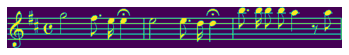

In [ ]:
show_img(music_dataset[14])

In [ ]:
n_all_det = len(SOMEDATASET)
n_used_det = int(1 * n_all_det)
n_train_det = int(0.8 * n_used_det)
n_test_det = n_used_det - n_train_det
rng_det = torch.Generator().manual_seed(291)
dataset_train_det, dataset_test_det, _ = torch.utils.data.random_split(SOMEDATASET, [n_train_det, n_test_det, n_all_det-n_train_det-n_test_det], rng_det)

NameError: ignored